# Experiment Tracking and Model Management

![Status](https://img.shields.io/static/v1.svg?label=Status&message=Finished&color=green)

<!-- Place this tag where you want the button to render. -->
<a class="github-button" href="https://github.com/particle1331/steepest-ascent" data-color-scheme="no-preference: dark; light: light; dark: dark;" data-icon="octicon-star" data-size="large" data-show-count="true" aria-label="Star particle1331/steepest-ascent on GitHub">Star</a>
<!-- Place this tag in your head or just before your close body tag. -->
<script async defer src="https://buttons.github.io/buttons.js"></script> 


In this module, we will look **experiment tracking** and **model management**. A machine learning experiment is defined as a session or process of making machine learning models. Experiment tracking is the process of keeping track of all relevant information in an experiments. This includes source code, environment, data, models, hyperparameters, and so on which are important for reproducing the experiment as well as for making actual predictions. 

From experience, we know that manual tracking, e.g. with spreadsheets, is error prone, not standardized, has low visibility, and difficult for teams to collaborate over. As an alternative, we will experiment tracking platforms such as [MLFlow](https://mlflow.org/). MLFlow has four main components: tracking, models, model registry, and projects. In this course, we only be cover the first three. 

```{margin}
⚠️ **Attribution:** These are notes for [Module 2](https://github.com/DataTalksClub/mlops-zoomcamp/tree/main/02-experiment-tracking) of the [MLOps Zoomcamp](https://github.com/DataTalksClub/mlops-zoomcamp). The MLOps Zoomcamp is a free course from [DataTalks.Club](https://github.com/DataTalksClub).
```

As we have seen with our previous prototyping, having the ability to reproduce results is important since we want to have the same results when deploying the model in different environments. Using experiment tracking and model management platforms allows us to have better chance at reproducing our results, as well as aid in organization (staging and deploying models) and optimization (finding the best models). 

## Getting started: MLFlow UI

We can run the MLFlow UI with an SQLite backend as follows:


```bash
$ mlflow ui --backend-store-uri sqlite:///mlflow.db

[2022-05-26 19:35:22 +0800] [92498] [INFO] Starting gunicorn 20.1.0
[2022-05-26 19:35:22 +0800] [92498] [INFO] Listening at: http://127.0.0.1:5000 (92498)
[2022-05-26 19:35:22 +0800] [92498] [INFO] Using worker: sync
[2022-05-26 19:35:22 +0800] [92499] [INFO] Booting worker with pid: 92499
```

For our experiment, we will use our code and data from [Module 1](https://particle1331.github.io/inefficient-networks/notebooks/mlops/1-intro.html). So before doing any run, we either create an **experiment** or connect a run to it if the experiment already exists. This also sets the experiment tracking backend. The same one that is visualized in the UI above.

```{margin}
[`experiment_lr.py`](https://github.com/particle1331/inefficient-networks/blob/mlops/docs/notebooks/mlops/2-mlflow/experiment_lr.py#L19-L21)
```

```python
import mlflow

mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_experiment("nyc-taxi-experiment")
```

The next section of the code executes a **single run** of the experiment. Note the logging at the end of the script. Everything that runs inside the following context is a single run:

```{margin}
[`experiment_lr.py`](https://github.com/particle1331/inefficient-networks/blob/mlops/docs/notebooks/mlops/2-mlflow/experiment_lr.py#L25-L53)
```
```python
with mlflow.start_run():

    # Train model
    model = LinearRegression()
    model.fit(X_train, y_train)

    # Plot predictions vs ground truth
    fig = plot_duration_distribution(model, X_train, y_train, X_valid, y_valid)
    fig.savefig('plot.svg')

    # Print metric
    rmse_train = mean_squared_error(y_train, model.predict(X_train), squared=False)
    rmse_valid = mean_squared_error(y_valid, model.predict(X_valid), squared=False)

    # Logging
    mlflow.set_tag('author', 'particle')
    mlflow.set_tag('model', 'sklearn')
    
    mlflow.log_param('train_data_path', train_data_path)
    mlflow.log_param('valid_data_path', valid_data_path)
    
    mlflow.log_metric('rmse_train', rmse_train)
    mlflow.log_metric('rmse_valid', rmse_valid)
    
    mlflow.log_artifact(ARTIFACTS_DIR / 'dict_vectorizer.pkl', artifact_path='preprocessing')
    mlflow.log_artifact(ARTIFACTS_DIR / 'transforms.pkl', artifact_path='preprocessing')
    mlflow.log_artifact(ARTIFACTS_DIR / 'categorical.pkl', artifact_path='preprocessing')
    mlflow.log_artifact(ARTIFACTS_DIR / 'numerical.pkl', artifact_path='preprocessing')
    mlflow.log_artifact(ARTIFACTS_DIR / 'plot.svg')
```

This will reflect in the UI as a single run in the `nyc-tax-experiment` experiment. MLFlow is able to obtain the version from `git` and the user from the system, i.e. the user that is currently logged in. The other values are obtained from the logs. 

```{figure} ../../../img/single-run-mlflow.png
```

If we click on the run, we can see more details about it that we logged. Shown here are the date of the run, the user that executed it, total run time, the source code used, as well as the git commit for this code. Status `FINISHED` indicates that the script successfully ran. These are useful metadata.

```{figure} ../../../img/single-run-mlflow-details.png
```

Regarding the details of the trained model, we have parameters for the data used (only paths, no versioning). Most importantly, we can see the logged RMSEs `5.7` (train) and `7.759` (valid). The plot of the distributions of the true and predicted distributions, which we logged as a training artifact, is also conveniently displayed here. Last, but not least, we log the artifacts that will be needed for reproducing the preprocessing performed on the raw data.

```{figure} ../../../img/mlflow-filter-tags.png
```

## Experiment tracking

In this section, we switch to a more complex XGBoost model and perform hyperparameter optimization using [Hyperopt](https://hyperopt.github.io/hyperopt/). We show how this looks in MLFlow. Note that it is easy to select the best models in an experiment by simply clicking the column header of the metrics. We also look at **auto logging** which makes logging simpler for frameworks with MLFlow integration.

```{margin}
[`experiment_xgb.py`](https://github.com/particle1331/inefficient-networks/blob/mlops/docs/notebooks/mlops/2-mlflow/experiment_xgb.py)
```
```python
mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_experiment("nyc-taxi-experiment")
mlflow.xgboost.autolog(disable=True)


def objective(params):
    """Compute RMSE. One trial = one run."""
    
    with mlflow.start_run(run_name='xgb'):
        
        booster = xgb.train(
            params=params,
            dtrain=xgb_train,
            num_boost_round=1000,
            evals=[(xgb_valid, 'validation')],
            early_stopping_rounds=50
        )

        rmse_valid = mean_squared_error(y_valid, booster.predict(xgb_valid), squared=False)
        rmse_train = mean_squared_error(y_train, booster.predict(xgb_train), squared=False)
        
        mlflow.log_params(params)
        mlflow.log_metric("rmse_valid", rmse_valid)
        mlflow.log_metric("rmse_train", rmse_train)
        mlflow.xgboost.log_model(booster, 'xgb-model')
        mlflow.set_tag('model', 'xgboost')

    return {'loss': rmse_valid, 'status': STATUS_OK}


search_space = {
    'max_depth': scope.int(hp.quniform('max_depth', 4, 100, 1)),
    'learning_rate': hp.loguniform('learning_rate', -3, 0),
    'reg_alpha': hp.loguniform('reg_alpha', -5, -1),
    'reg_lambda': hp.loguniform('reg_lambda', -6, -1),
    'min_child_weight': hp.loguniform('min_child_weight', -1, 3),
    'objective': 'reg:squarederror',
    'seed': 42
}


# Perform 50 runs with TPE algo
best_result = fmin(
    fn=objective,
    space=search_space,
    algo=tpe.suggest,
    max_evals=50,
    trials=Trials()
)

```

### Trying out different models
Note that we section the code in three parts: 1) a `setup` function which sets up the information used in the runs, 2) a `run` function which executes a single run, and 3) a `main` function which executes multiple runs of the `run` function. 


we wont use autolog for xgbooist to make the runs faster. but it can be used by 


always commit before running experiments. this ties your experiment with a specific commit or version of the source code.

## Model management

In this section, we look at **model management**. In addition to experiment tracking, part of model management is to do model versioning and model deployment. Model management using file systems (which typically just involve a file name and date modified) is error prone. There is no versioning and no model lineage. Mode lineage refers to all associations between a model and all components involved in its creation.

**Reading**
* [Model and data lineage in machine learning experimentation](https://aws.amazon.com/blogs/machine-learning/model-and-data-lineage-in-machine-learning-experimentation/)

1. Most basic:
* `log_artifact(path, artifact_path)`

artifact path is simply the path relative to the experiment run folder where MLFlow will save the artifact. Recall we previously saved the plot distribution as artifact.  

2. `<framework>.log_model`

either python function, or flavor.

MLFLow model format can be deployed to different platforms. 


mlflow.log_model

MLModel stores information about the model, flavors, path (where model lives), serves model as python function or an xgboost model. versions are stated, as well as conda yaml file or requirements for describing environment of model. 

we can also log the preprocessor, 

also feature importances are saved, here importance is set for each combination of pu and do location id.  

## Model registry

New model -> good performance -> plz deploy. 

what has changed? is there any preprocessing needed? what is the environment, what are the dependencies? 

back and fort communication with data scientist.

what if incident in prod, need rollback, need to go to email inbox. imagine its not possible to run this model again, have to retrain from scratch. but what if retraining information is lost, no idea of env used, which dataset, and so on. 

recall we have tracking server, which stored experiment runs. model registry has stages. staging -> prod -> archive. DS only decides which models are ready for prod. deployment engineer not responsible. 

then if we want rollback, we can go back from archive to prod. note that model registry not deployment. it just labels models. need to compliment with ci/cd. in order to do actual deployment. 



comparing models: 
- look at duration, and model size, rmse


information you need to consider

In [2]:

from utils import set_datasets, plot_duration_distribution

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.linear_model import Lasso, Ridge
from sklearn.metrics import mean_squared_error

import mlflow


# Set datasets
train_data_path = '../data/green_tripdata_2021-01.parquet'
valid_data_path = '../data/green_tripdata_2021-02.parquet'
X_train, y_train, X_valid, y_valid = set_datasets(train_data_path, valid_data_path)

X_train.shape

(73908, 17350)

In [22]:
from utils import RUNS_DIR, preprocess_test, DATA_DIR
import pandas as pd
import joblib
import mlflow

run_path = RUNS_DIR / '1' / 'faade249567549fca12e910b59b6469d'
model_path = run_path / 'artifacts' / 'model'
model_artifacts_path = run_path / 'artifacts' / 'preprocessing'

dv = joblib.load(model_artifacts_path / 'dict_vectorizer.pkl')
transforms = joblib.load(model_artifacts_path / 'transforms.pkl')
categorical = joblib.load(model_artifacts_path / 'categorical.pkl')
numerical = joblib.load(model_artifacts_path / 'numerical.pkl')

train_data_path = DATA_DIR / 'green_tripdata_2021-01.parquet'
valid_data_path = DATA_DIR / 'green_tripdata_2021-02.parquet'

train_data = preprocess_test(pd.read_parquet(train_data_path), dv, transforms, categorical, numerical)
valid_data = preprocess_test(pd.read_parquet(valid_data_path), dv, transforms, categorical, numerical)

In [42]:
from utils import set_datasets

# Set datasets
train_data_path = '../data/green_tripdata_2021-01.parquet'
valid_data_path = '../data/green_tripdata_2021-02.parquet'

X_train, y_train, X_valid, y_valid = set_datasets(train_data_path, valid_data_path)

/Users/particle1331/code/inefficient-networks/docs/notebooks/mlops/2-mlflow/utils.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['PU_DO'] = df['PULocationID'].astype(str) + '_' + df['DOLocationID'].astype(str)
/Users/particle1331/code/inefficient-networks/docs/notebooks/mlops/2-mlflow/utils.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[categorical] = df[categorical].astype(str)
/Users/particle1331/code/inefficient-networks/docs/notebooks/mlops/2-mlflow/utils.py:20: SettingWithCopyWarning:

In [41]:
from sklearn.metrics import mean_squared_error

loaded_model = mlflow.pyfunc.load_model(model_path)

print(mean_squared_error(y_train, loaded_model.predict(X_train), squared=False))
print(mean_squared_error(y_valid, loaded_model.predict(X_valid), squared=False))

4.272621269941186
6.43557380916725


<AxesSubplot:ylabel='Count'>

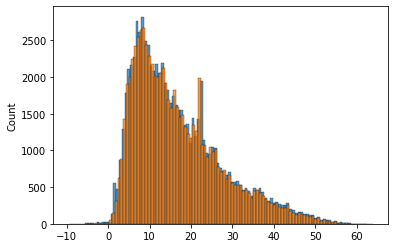

In [47]:
from sklearn.metrics import mean_squared_error
import seaborn as sns

sns.histplot(loaded_model.predict(train_data), color='C0')
sns.histplot(loaded_model.predict(X_train), color='C1')
# Recall X_train has been filtered to include only rides with duration (0, 60) minutes.

<AxesSubplot:ylabel='Count'>

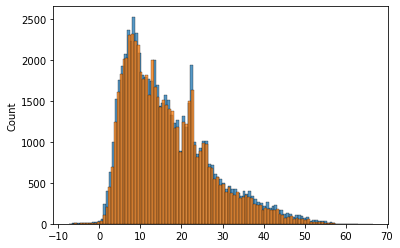

In [48]:
sns.histplot(loaded_model.predict(valid_data), color='C0')
sns.histplot(loaded_model.predict(X_valid), color='C1') 